# ADS-B Flight Localization

## Data inspection and visualization

We will begin the new project with the inspection and visualization of the raw dataset retrieved from [AIcrowd](https://www.aicrowd.com/challenges/cyd-campus-aircraft-localization-competition#data-sets), which is a part of the Aircraft Localization Competition powered by <b>OpenSky Network</b> and <b>Cyber-Defence Campus - armasuisse</b>. The notebook will walk you through the process of loading the data, examining the distribution of the features and visualizing an example flight in conjunction with recorded flight parameters such as timestamp, timeAtServer, received signal strength indicator (RSSI), barometric and GPS altitude.

Both training and competition (evaluation) data sets are provided as CSV files. Each CSV file contains the data that was recorded by the OpenSky Network over a duration of 1 hour. Each row in the CSV file represents the reception of one aircraft position report and contains the following information:

- id: a unique ID for each transponder transmission
- timeAtServer: timestamp denoting the time when the measurement arrived at OpenSky’s server. Unit is seconds and it starts at timeAtServer=0 in each data set
- aircraft: a randomized ID of the aircraft which sent the position report
- latitude: latitude reported by the aircraft in decimal degrees
- longitude: longitude reported by the aircraft in decimal degrees
- baroAltitude: barometric altitude reported by the aircraft in meters
- geoAltitude: geometric (GPS) height reported by the aircraft in meters
- numMeasurements: the number of sensors which recorded the position report
- measurements: JSON array of triples [sensorID, timestamp, signalstrength]
   - serial: unique sensor ID which can be matched with the sensor information table
   - timestamp: precise timestamp for the detection of the position report at the sensor in nanoseconds
   - signalstrength: indicator of the strength of the report’s signal at the sensor (in dB)


The metadata of sensors includes:

- serial: unique sensor ID which can be used to join the sensor information with the measurements data
- latitude: latitude of the sensor in decimal degrees
- longitude: longitude of the sensor in decimal degrees
- height: height of the sensor in meters
- type: type of the sensor hardware that was used to record the measurements
   

<p>Dataset folder structure is as follows:</p>
<p>round2_training/<br>
&ensp;&ensp;&ensp;&ensp;├── round2/<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;  ├── round2_training1.csv<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;  ├── round2_training2.csv <br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;  ├── round2_training3.csv <br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;  ├── round2_sensors.csv <br>
    
<p>round2_competition_data/<br>
&ensp;&ensp;&ensp;&ensp; ├── round2_competition.csv<br>
&ensp;&ensp;&ensp;&ensp; ├── round2_sensors.csv <br>

More detailed background information on the provided data can be found [here](https://competition.opensky-network.org/documentation.html)

### Loading the data

We will begin with importing all indispensable libraries that will be used in this notebook.

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D

To load and display the data we will use the <i>pandas</i> library.

In [2]:
flights = pd.read_csv("round2_training/round2/round2_training1.csv")

In [3]:
flights.head()

,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements
0,1,0.000,109,51.606740,-0.204849,2590.80,2590.80,5,"[[532,969020406,89],[216,969100125,23],[169,39..."
1,2,0.000,840,51.280781,-0.698624,8907.78,8846.82,9,"[[532,976779968,72],[185,268603093,64],[207,23..."
2,3,0.000,1819,51.354567,-0.304184,5791.20,5722.62,8,"[[532,980862171,91],[294,980898968,101],[169,3..."
3,4,0.001,794,36.926864,-9.295270,11582.40,11658.60,2,"[[136,927757328,52],[163,74974406666.6667,19]]"
4,5,0.001,719,46.953053,14.289973,10972.80,10820.40,6,"[[149,957322046,48],[143,957512484,102],[133,9..."


### Measurements distribution

In this step, we will examine the distribution of the number of provided measurements, that stem from the number of sensors that received this particular transponder signal. To confine the number of input features to our model we will have to pick out the threshold of measurements.

In [4]:
meas_stats = pd.DataFrame(flights.numMeasurements.describe(percentiles=[0.5, 0.75, 0.9, 0.95]).round())
meas_stats

,numMeasurements
count,6535444.0
mean,4.0
std,3.0
min,2.0
50%,3.0
75%,6.0
90%,8.0
95%,10.0
max,30.0


The preceding table contains the basic statistics of the distribution of the measurements. As we can see some data points comprise as high as 30 measurements, while the median value is 3 and the mean of <i>numMeasurements</i> equals 4.

Now we will depict the same values at a plot.

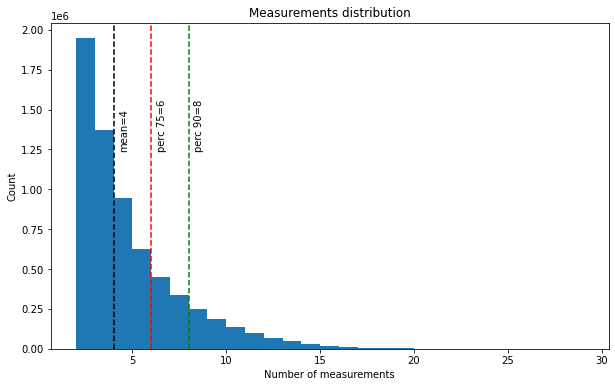

In [5]:
plt.figure(figsize=(10,6))
plt.hist(flights.numMeasurements, bins=range(2, 30))

mean = int(meas_stats.loc['mean'])
plt.axvline(mean, linestyle='--', c='k')
plt.text(mean+0.3, 1.25e6, 'mean={}'.format(mean), rotation=90)

p75 = int(meas_stats.loc['75%'])
plt.axvline(p75, linestyle='--', c='r')
plt.text(p75+0.3, 1.25e6, 'perc 75={}'.format(p75), rotation=90)

p90 = int(meas_stats.loc['90%'])
plt.axvline(p90, linestyle='--', c='g')
plt.text(p90+0.3, 1.25e6, 'perc 90={}'.format(p90), rotation=90)

plt.xlabel('Number of measurements')
plt.ylabel('Count')
plt.title('Measurements distribution')
plt.show()

The measurements distribution is right-skewed - the mean is to the right of the median. I assumed the measurement threshold to be equal to the 75th percentile (6 measurements).

### Visualize an example flight

To shed some light on the raw numbers from the dataset, we are going to utilize the <i>Matplotlib Basemap</i> to depict the route of a chosen aircraft on a 3D plot.

First of all, we have to find some flights that flew above the area of interest, which in this case is England.

In [6]:
# Find some flights over England
flights.loc[flights.latitude.between(50, 57) & flights.longitude.between(-2, 2)].head(10)

,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements
0,1,0.000,109,51.606740,-0.204849,2590.80,2590.80,5,"[[532,969020406,89],[216,969100125,23],[169,39..."
1,2,0.000,840,51.280781,-0.698624,8907.78,8846.82,9,"[[532,976779968,72],[185,268603093,64],[207,23..."
2,3,0.000,1819,51.354567,-0.304184,5791.20,5722.62,8,"[[532,980862171,91],[294,980898968,101],[169,3..."
13,14,0.003,2041,54.971786,-0.496647,11277.60,11170.92,5,"[[184,4328242833.33333,20],[695,19964177833.33..."
15,16,0.003,1143,51.708206,1.012004,5090.16,5036.82,5,"[[455,15742152000,40],[583,-1230441000,14],[35..."
61,62,0.016,2417,51.322037,-1.859510,10668.00,10523.22,11,"[[185,279306140,108],[466,58027029250,92],[207..."
100,101,0.029,530,55.087646,-1.923981,8633.46,8618.22,3,"[[658,5878005000,122],[173,47227934083.3333,17..."
107,108,0.030,2676,51.966775,-1.447135,8839.20,8778.24,3,"[[207,23876496250,153],[521,81620067916.6667,1..."
108,109,0.030,1419,51.573990,1.027073,7376.16,7338.06,7,"[[207,23879446000,176],[327,968632406,96],[304..."
143,144,0.042,181,51.087204,-0.031846,1584.96,1524.00,2,"[[169,39359471416.6667,39],[700,66359167250,11]]"


I decided to pick out flight number 181.

In [7]:
air181 = flights.loc[flights.aircraft == 181].copy()

Now we can create the scatter3D plot with the latitude, longitude and geoAltitude as the XYZ axes respectively. To ensure that our data is properly displayed we need to set the map's coordinate system to EPSG:4326.

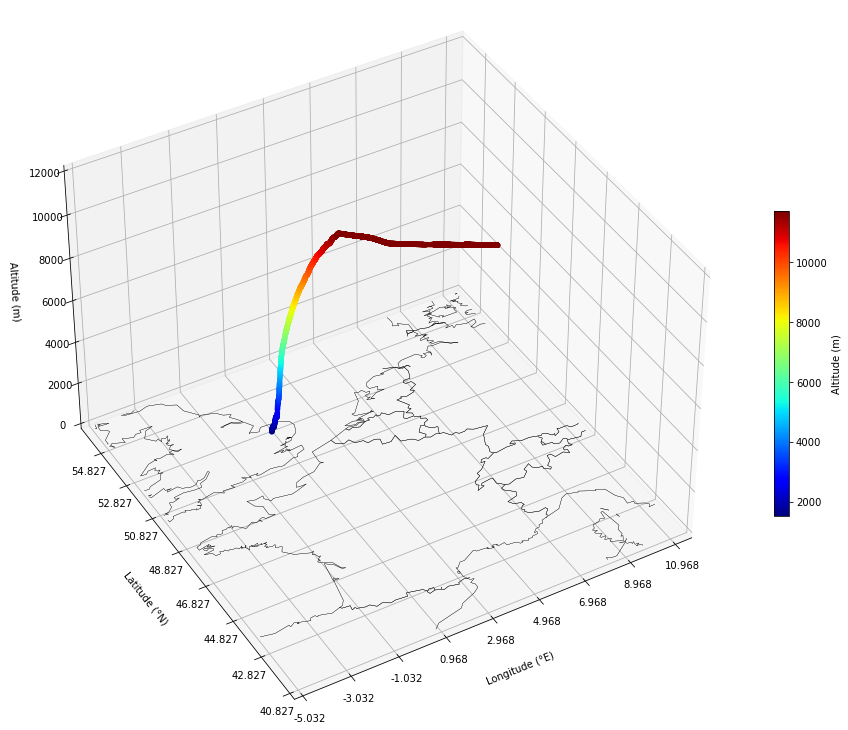

In [8]:
lat = air181.latitude.values
long = air181.longitude.values
geoAltitude = air181.geoAltitude.values

# Create a figure with 3d projection
fig = plt.figure(figsize=(16,14))
ax = fig.gca(projection='3d')

# Define lower left, uperright lattitude and longitude respectively
ll_lat, up_lat, ll_long, up_long = min(lat)-5, max(lat)+5, min(long)-5, max(long)+5

# Create a Basemap instance
bm = Basemap(llcrnrlon=ll_long, llcrnrlat=ll_lat,
             urcrnrlon=up_long, urcrnrlat=up_lat,
             epsg=4326, resolution='l',
             fix_aspect=False, ax=ax) 

# Add Basemap to the figure
ax.add_collection3d(bm.drawcoastlines(linewidth=0.25))
ax.add_collection3d(bm.drawcountries(linewidth=0.35))
ax.view_init(azim=240, elev=40)
ax.set_xlabel('Longitude (°E)', labelpad=15)
ax.set_ylabel('Latitude (°N)', labelpad=15)
ax.set_zlabel('Altitude (m)', labelpad=15)

# Add meridian and parallel gridlines
meridians = np.arange(ll_long, up_long, 2)
parallels = np.arange(ll_lat, up_lat, 2)
ax.set_yticks(parallels)
ax.set_yticklabels(np.round(parallels, 3))
ax.set_xticks(meridians)
ax.set_xticklabels(np.round(meridians, 3))
ax.set_zlim(0, 12000)

plot = ax.scatter3D(long, lat, geoAltitude, c=geoAltitude, cmap="jet")
fig.colorbar(plot, label='Altitude (m)', shrink=0.4)

plt.show()

As we can see on the preceding plot, the aircraft apparently has just taken off from London, swiftly gaining altitude from 1600 m as noted by the first datapoint up to a cruise altitude at around 12000 m. We can see that the aircraft is heading towards the south-east. The recording stopped an hour later when the plane was flying near Marseille, France.

### Timestamp measurements

The timestamp is the date and time on which the ADS-B message was recorded by the receiver, accurate to nanoseconds. Having such information we are able to determine the location of an aircraft measuring the time difference in the signal reception on the several pairs of ground stations (time  differences  of  arrival - TDoA). Nevertheless, firstly we have to examine whether the timestamps are not broken, which could distort the results.

In the first place, we have to extract the measurements data from the JSON array.

In [9]:
# [serial number of the sensor, timestamp of the arrival at the receiver (in nanoseconds), strength indicator (RSSI)]
air181.measurements = air181.measurements.apply(lambda row: json.loads(row))

We will explode the measurements field so that the sensor, timestamp and RSSI information of each measurement is presented as a separate column.

In [10]:
air181_exp = pd.concat([air181, air181.measurements.apply(pd.Series)], axis=1)

In [11]:
for col in range(max(air181.numMeasurements)):
    meas_columns = air181_exp[col].apply(pd.Series)
    
    col_names = {0: "{}_sensor".format(col),
                 1: "{}_tmp".format(col),
                 2: "{}_rssi".format(col)}
    
    meas_columns.rename(mapper=col_names, axis=1, inplace=True)
    air181_exp = pd.concat([air181_exp, meas_columns], axis=1)
    air181_exp.drop(columns=col, inplace=True)

Now we can take a look at the dataframe with the new columns added. 

In [12]:
air181_exp.head()

,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements,0_sensor,...,7_rssi,8_sensor,8_tmp,8_rssi,9_sensor,9_tmp,9_rssi,10_sensor,10_tmp,10_rssi
143,144,0.042,181,51.087204,-0.031846,1584.96,1524.00,2,"[[169, 39359471416.6667, 39], [700, 6635916725...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1884,1885,1.016,181,51.086243,-0.031326,1592.58,1531.62,4,"[[399, 15390701166.6667, 55], [169, 4033950525...",399.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2671,2672,1.462,181,51.085727,-0.031052,1592.58,1524.00,2,"[[169, 40809516916.6667, 29], [700, 6780920916...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4724,4725,2.610,181,51.084366,-0.030212,1600.20,1531.62,3,"[[169, 41914476083.3333, 38], [700, 6891416550...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5479,5480,3.044,181,51.083771,-0.030064,1607.82,1546.86,4,"[[169, 42369493666.6667, 44], [700, 6936918208...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we will plot the relationship between the sensor's timestamp and the time at which the message arrived at the OpenSky’s server.

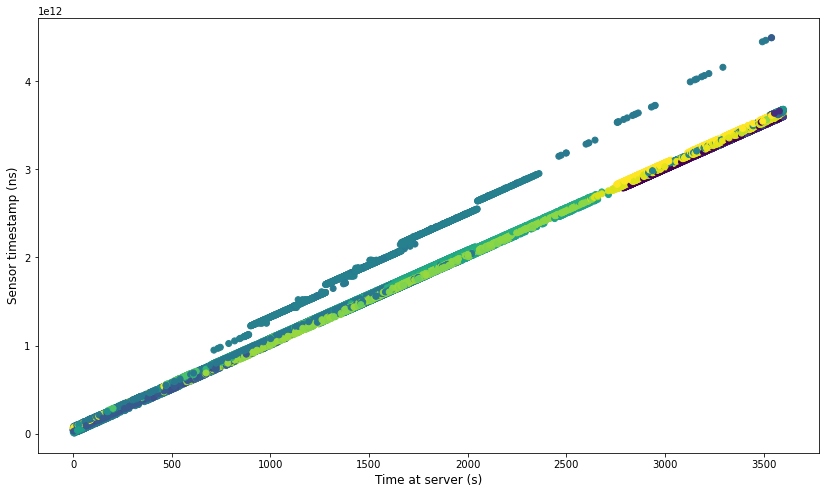

In [13]:
fig, ax = plt.subplots(figsize=(14, 8))

for sensor in range(max(air181.numMeasurements)):
    scatter = ax.scatter(air181_exp.timeAtServer, air181_exp['{}_tmp'.format(sensor)], 
               c=air181_exp['{}_sensor'.format(sensor)])

ax.set_xlabel('Time at server (s)', size=12)
ax.set_ylabel('Sensor timestamp (ns)', size=12)

plt.show()

As we can see, there are some broken timestamps in the dataset, namely the timestamps of sensors that correspond to the highest line on the plot. Those data points indicate the inconsistency between the amount of the time that elapsed according to the ground receiver (sensor timestamp) and the OpenSky’s server.

Next, we will perform calculations of the timestamp differences between the sensors, which can help us to pinpoint the broken timestamps. The ADS-B message usually is received by the closest ground stations, thus the time difference of arrivals of the same message at distinct receivers should be very small (depends on the distance difference between aircraft and receivers).

In [14]:
meas_values = air181_exp.loc[:, ['{}_tmp'.format(sensor) for sensor in range(max(air181.numMeasurements))]].values

In [15]:
tmp_columns = ['{}_tmp'.format(sensor) for sensor in range(max(air181.numMeasurements))]

for col in range(1, max(air181.numMeasurements)):
    for col2 in range(col):
        air181_exp['diff_{}_{}'.format(col, col2)] = np.NaN

for i, row in air181_exp.iterrows():
    tmp_values = row[tmp_columns]
    
    for col in range(1, max(air181.numMeasurements)):
        for col2 in range(col):
            air181_exp.loc[i, 'diff_{}_{}'.format(col, col2)] = tmp_values[col] - tmp_values[col2]


In [17]:
air181_exp.head()

,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements,0_sensor,...,diff_10_0,diff_10_1,diff_10_2,diff_10_3,diff_10_4,diff_10_5,diff_10_6,diff_10_7,diff_10_8,diff_10_9
143,144,0.042,181,51.087204,-0.031846,1584.96,1524.00,2,"[[169, 39359471416.6667, 39], [700, 6635916725...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1884,1885,1.016,181,51.086243,-0.031326,1592.58,1531.62,4,"[[399, 15390701166.6667, 55], [169, 4033950525...",399.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2671,2672,1.462,181,51.085727,-0.031052,1592.58,1524.00,2,"[[169, 40809516916.6667, 29], [700, 6780920916...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4724,4725,2.610,181,51.084366,-0.030212,1600.20,1531.62,3,"[[169, 41914476083.3333, 38], [700, 6891416550...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5479,5480,3.044,181,51.083771,-0.030064,1607.82,1546.86,4,"[[169, 42369493666.6667, 44], [700, 6936918208...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we will plot the timestamp differences.

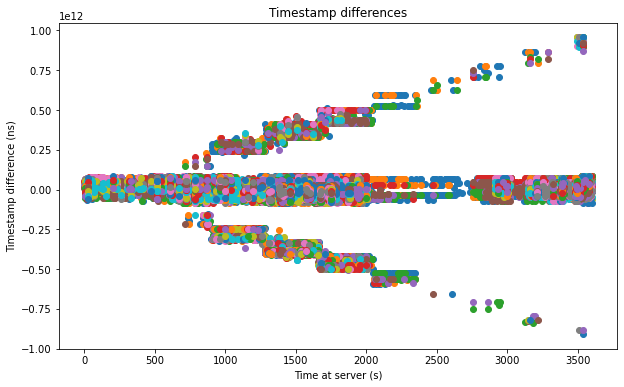

In [18]:
columns_list = [col for col in air181_exp.columns if 'diff' in col]

plt.figure(figsize=(10, 6))

for col in columns_list:
    plt.scatter(air181_exp.timeAtServer, air181_exp[col])
    
plt.xlabel('Time at server (s)')
plt.ylabel('Timestamp difference (ns)')
plt.title('Timestamp differences')

plt.show()

The plot bespeaks that most of the timestamp differences are concentrated around the zero value, while the incorrect timestamps lead to forming two branches that are leading away from the centre, which as a result could cause immense localization error (hundreds of kilometres). To prevent that we will later conduct the timestamp synchronization.

To explore in more detail how the timestamp difference of a pair of sensors is changing during the flight, we will pick out only two adjacent sensors and depict their timestamp differences on a plot.

In [19]:
sensor_numbers = [207, 425]
find_col = 'diff'

In [20]:
def find_sensor_values(df, sensor_numbers, find_col):
    """Find the values of a 'find_col' field that are associated with the given 'sensor_number'.
    
    Parameters
    ----------
    df: pandas.DataFrame
        Pandas.DataFrame containing sensor columns and given 'find_col' field.
    sensor_numbers: int or list of int
        Integer value for a single sensor number or a list of sensor's serials.
    find_col: str
        String representing the name of a field.
    
    Returns
    -------
    sensor_values: list
        List of 'find_col' values.
    sensors_idx: list
        List of sensor's indices in the dataset.
        
    """
    
    if isinstance(sensor_numbers, int):
        sensor_numbers = [sensor_numbers]

    sensor_columns = [col for col in df.columns if 'sensor' in col]

    sensors_idx = []
    sensors_cols = []
    sensor_values = []

    filtered_sensors = df[sensor_columns].isin(sensor_numbers)
    filtered_sensors = filtered_sensors.loc[filtered_sensors.sum(axis=1) >=len(sensor_numbers)]

    for i, row in filtered_sensors.iterrows():
        cols = list(row.loc[row == True].index)
        cols = [col.strip('_sensor') for col in cols]
        if find_col == 'diff':
            cols = find_col + '_' + cols[1] + '_' + cols[0] 
        else:
            assert len(sensor_numbers) == 1, 'For column: {}, you have to provide only one sensor number'.format(find_col)
            
            cols = cols[0] + '_' + find_col

        sensors_idx.append(i)
        sensors_cols.append(cols)

    for i, idx in enumerate(sensors_idx):
        sensor_values.append(df.loc[idx, sensors_cols[i]])
        
    return sensor_values, sensors_idx

In [21]:
values_to_plot, sensors_idx = find_sensor_values(air181_exp, sensor_numbers, find_col)

After finding the data of chosen sensors we will show it on a plot.

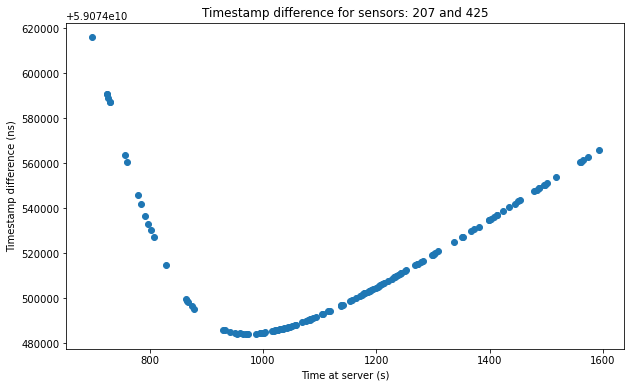

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(air181_exp.loc[sensors_idx, 'timeAtServer'], np.abs(values_to_plot))
plt.xlabel('Time at server (s)')
plt.ylabel('Timestamp difference (ns)')
plt.title('Timestamp difference for sensors: {} and {}'.format(sensor_numbers[0], sensor_numbers[1]))

plt.show()

The timestamp differences plot for sensors 207 and 425 shows that for the first phase of the flight (up to 950 seconds), the difference of timestamps diminishes which indicates that the aircraft is heading towards one of the ground stations, while in the second phase (starting from 950 seconds), the difference increases suggesting that an aircraft moves away from both receivers.

As the timestamp difference is inconvenient to measure the aircraft's relative position, we will now calculate and plot the distance differences.

To find out the distance difference between the airplane and the receiver's location we have to know the coordinates of both of them. 

In [23]:
dist_diff = air181_exp.loc[sensors_idx, ['timeAtServer', 'latitude', 'longitude', 'geoAltitude']]

In [24]:
dist_diff.head()

,timeAtServer,latitude,longitude,geoAltitude
1258065,697.317,50.101939,0.413398,8054.34
1307454,724.586,50.064056,0.462221,8282.94
1307455,724.586,50.064056,0.462221,8275.32
1311106,726.593,50.061127,0.465907,8290.56
1314762,728.622,50.058197,0.469449,8313.42


In [25]:
sensor_data = pd.read_csv("round2_training/round2/round2_sensors.csv")

Below we will define two functions. The first one will be responsible for converting  WSG84 coordinates to cartesian ones, while the later for calculating the Euclidean distance between two coordinates (high accuracy is not required).

In [26]:
def lla_to_ecef(latitude, longitude, altitude):
    """Converts WSG84 coordinates to cartesian ones.
    
    """
    
    latitude = np.radians(latitude)
    longitude = np.radians(longitude)

    # WSG84 ellipsoid constants
    a = 6378137
    e = 8.1819190842622e-2

    # Prime vertical radius of curvature
    N = a / np.sqrt(1 - e**2 * np.sin(latitude)**2)

    x = (N + altitude) * np.cos(latitude) * np.cos(longitude)
    y = (N + altitude) * np.cos(latitude) * np.sin(longitude)
    z = ((1 - e**2) * N + altitude) * np.sin(latitude)
    
    return x, y, z

In [27]:
def calculateDist(row, sensor):
    """Calculates the Euclidean distance between two coordinates.
    
    """
    
    x1, y1, z1 = row.latitude, row.longitude, row.geoAltitude
    x2, y2, z2 = sensor_data.loc[sensor-1, ['latitude', 'longitude', 'height']] 
    
    x1, y1, z1 = lla_to_ecef(x1, y1, z1)
    x2, y2, z2 = lla_to_ecef(x2, y2, z2)
    
    return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) / 1000

Now we can calculate the distance between an airplane and all available sensors, which in our case are:
- distance between an aircraft and a sensor's 207 location
- distance between an aircraft and a sensor's 425 location

In [28]:
for sensor in sensor_numbers:
    dist_diff['sensor{}_dist'.format(sensor)] = dist_diff.apply(calculateDist, args=(sensor,), axis=1)

In [29]:
dist_diff.head(10)

,timeAtServer,latitude,longitude,geoAltitude,sensor207_dist,sensor425_dist
1258065,697.317,50.101939,0.413398,8054.34,189.332676,38.700603
1307454,724.586,50.064056,0.462221,8282.94,194.634343,35.075126
1307455,724.586,50.064056,0.462221,8275.32,194.633910,35.073313
1311106,726.593,50.061127,0.465907,8290.56,195.041509,34.811543
1314762,728.622,50.058197,0.469449,8313.42,195.445219,34.552804
1314763,728.622,50.058197,0.469449,8305.80,195.444785,34.550958
1364766,756.079,50.019495,0.518733,8526.78,200.854199,31.481935
1372221,760.167,50.014002,0.526008,8572.50,201.632195,31.113940
1406887,778.930,49.987327,0.559857,8702.04,205.362067,29.501403
1417746,784.877,49.978762,0.570695,8740.14,206.559497,29.070530


Let's look at how the distance difference between calculated values presents on a plot.

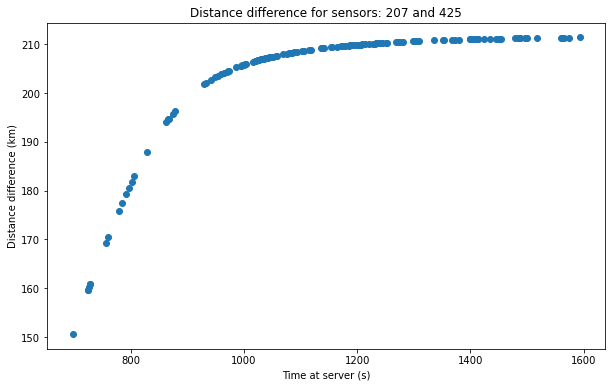

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(dist_diff.timeAtServer, dist_diff['sensor{}_dist'.format(sensor_numbers[0])] - 
            dist_diff['sensor{}_dist'.format(sensor_numbers[1])])
plt.xlabel('Time at server (s)')
plt.ylabel('Distance difference (km)')
plt.title('Distance difference for sensors: {} and {}'.format(sensor_numbers[0], sensor_numbers[1]))

plt.show()

To see how the changes in timestamp and distance differences look in relation to the plane route, we will plot the aircraft positions during the flight together with the location of the chosen sensors.

Note that in order to use high resolution map you have to install the proper files with: <br>
<code>conda install -c conda-forge basemap-data-hires</code>

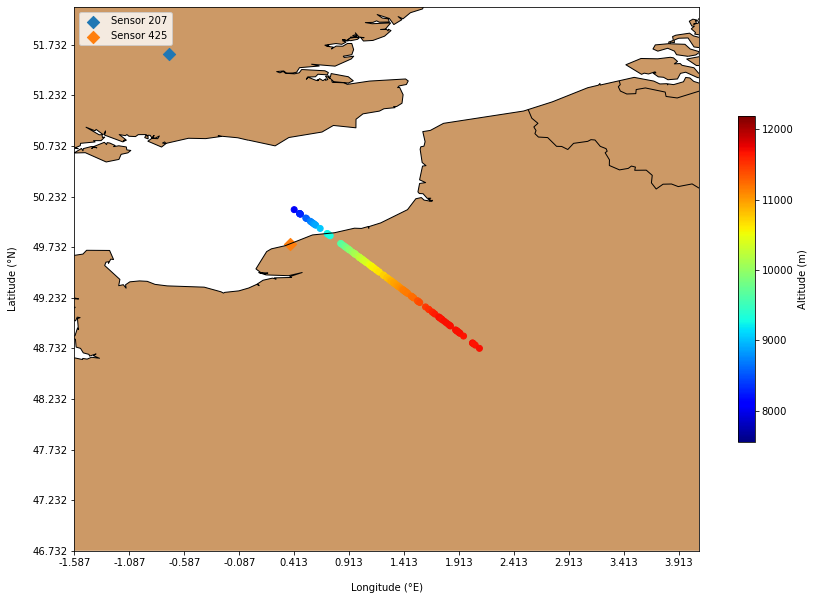

In [31]:
lat = dist_diff.latitude.values
long = dist_diff.longitude.values
geoAltitude = dist_diff.geoAltitude.values

fig, ax = plt.subplots(figsize=(14,10))

# Define lower left, uperright lattitude and longitude respectively
ll_lat, up_lat, ll_long, up_long = min(lat)-2, max(lat)+2, min(long)-2, max(long)+2

# Create a Basemap instance
# In order to use the resolutions highere than 'l' (low) you have to download and
# install those files separately with: conda install -c conda-forge basemap-data-hires
m = Basemap(llcrnrlon=ll_long, llcrnrlat=ll_lat,
             urcrnrlon=up_long, urcrnrlat=up_lat,
             epsg=4326, resolution='i',
             fix_aspect=False, ax=ax) 


s1x, s1y = sensor_data.loc[sensor_numbers[0]-1, ['latitude', 'longitude']]
s2x, s2y = sensor_data.loc[sensor_numbers[1]-1, ['latitude', 'longitude']]
                           
ax.scatter(s1y, s1x, label='Sensor {}'.format(sensor_numbers[0]), marker='D', s=75)
ax.scatter(s2y, s2x, label='Sensor {}'.format(sensor_numbers[1]), marker='D', s=75)
ax.legend()

m.drawcoastlines() # use only if coastline will be visible on the map
m.drawcountries(color='k', linewidth=1)
m.fillcontinents(color='#cc9966',lake_color='#99ffff', zorder=0)

plot = ax.scatter(long, lat, c=geoAltitude,  cmap="jet", vmin=min(geoAltitude)-500, vmax=max(geoAltitude)+500)
fig.colorbar(plot, label='Altitude (m)', shrink=0.6)

ax.set_xlabel('Longitude (°E)', labelpad=15)
ax.set_ylabel('Latitude (°N)', labelpad=15)

meridians = np.arange(ll_long, up_long, 0.5)
parallels = np.arange(ll_lat, up_lat, 0.5)
ax.set_yticks(parallels)
ax.set_yticklabels(np.round(parallels, 3))
ax.set_xticks(meridians)
ax.set_xticklabels(np.round(meridians, 3))

plt.show()

The map shows that the first position of the aircraft recorded by both sensors is above the English Channel near France's coastline. The plane gains altitude, heads to the south-east, approaching ground station 425 and passing it soon. We can see that as the plane is getting closer to the sensor 425, the distance difference between aircraft-sensor_207 and aircraft-sensor_425 increases, but when the plane passes the mentioned receiver both values of aircraft-sensor_207 and aircraft-sensor_425 are rising resulting in the distance difference being fairly constant.

### Signal Strength measurements

In this section, we are going to examine the significance of RSSI in terms of estimating aircraft localization.

The concrete approach that is taken is to use the received signal strength value (RSSI) of transmission to predict aircraft-receiver distance, based on an assumption that the longer the distance between sender and receivers, the worse the signal strength gets.

For the chosen flight we are going to plot the signal strength values for all the sensors that recorded aircraft position.

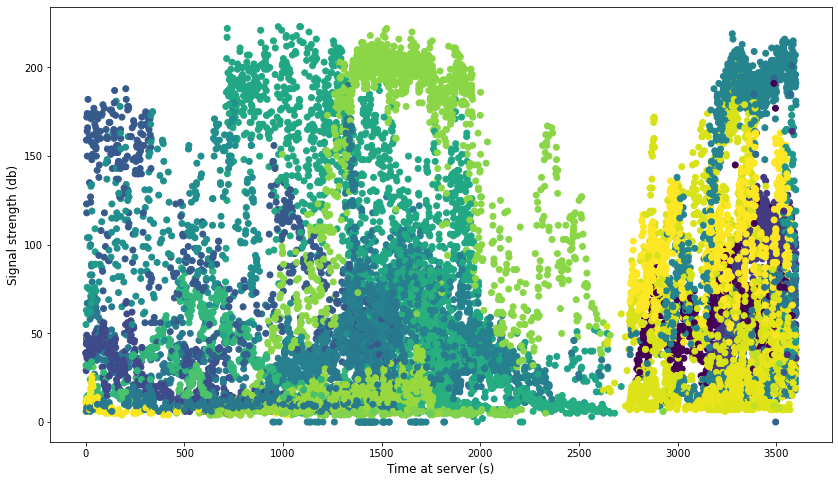

In [32]:
fig, ax = plt.subplots(figsize=(14, 8))

for sensor in range(max(air181.numMeasurements)):
    scatter = ax.scatter(air181_exp.timeAtServer, air181_exp['{}_rssi'.format(sensor)], 
               c=air181_exp['{}_sensor'.format(sensor)])

ax.set_xlabel('Time at server (s)', size=12)
ax.set_ylabel('Signal strength (db)', size=12)

plt.show()

As we can see in the preceding plot, the signal strength for a particular sensor seems to be bell-shaped (parabola), which means that signal strength increases while an airplane is approaching the sensor, and conversely, it decreases while moving away from the receiver's position. The data distribution is never uniform around the sensor. Additionally, we can discern the influence of the environment on signal propagation. 

Now we will depict the signal strength for a chosen sensor together with the calculated distance between the aircraft and the sensor.

In [33]:
sensor_numbers = [207, 425]

# Extract sensors RSSI data
s207_rssi, s207_idx  = find_sensor_values(air181_exp, sensor_numbers[0], 'rssi')
s425_rssi, s425_idx  = find_sensor_values(air181_exp, sensor_numbers[1], 'rssi')

# Calculate the distance between a sensor and an aircraft
s207_dist = air181_exp.loc[s207_idx].apply(calculateDist, args=(sensor_numbers[0],), axis=1)
s425_dist = air181_exp.loc[s425_idx].apply(calculateDist, args=(sensor_numbers[1],), axis=1)

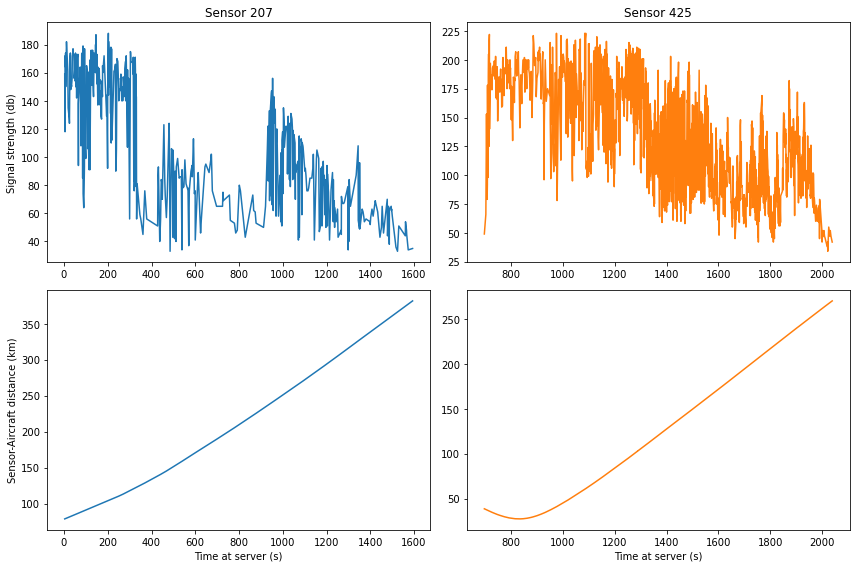

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

axes[1, 0].plot(air181_exp.loc[s207_idx, 'timeAtServer'], s207_dist, 
         label='sensor {} distance'.format(sensor_numbers[0]))
axes[1, 0].set_ylabel('Sensor-Aircraft distance (km)')
axes[1, 0].set_xlabel('Time at server (s)')

axes[0, 0].plot(air181_exp.loc[s207_idx, 'timeAtServer'], s207_rssi,
         label='sensor {} RSSI'.format(sensor_numbers[0]))
axes[0, 0].set_ylabel('Signal strength (db)')
axes[0, 0].set_title('Sensor {}'.format(sensor_numbers[0]))

axes[1, 1].plot(air181_exp.loc[s425_idx, 'timeAtServer'], s425_dist, 'tab:orange',
         label='sensor {} distance'.format(sensor_numbers[1]))
axes[1, 1].set_xlabel('Time at server (s)')

axes[0, 1].plot(air181_exp.loc[s425_idx, 'timeAtServer'], s425_rssi, 'tab:orange',
         label='sensor {} RSSI'.format(sensor_numbers[1]))
axes[0, 1].set_title('Sensor {}'.format(sensor_numbers[1]))

plt.tight_layout()

We can clearly discern the negative correlation between the RSSI and the aircraft-sensor distance - as the distance between the aircraft and the sensor increases the signal strength decreases. However there is a lot of noise, thus this variable seems to not have very much predictive abilities.

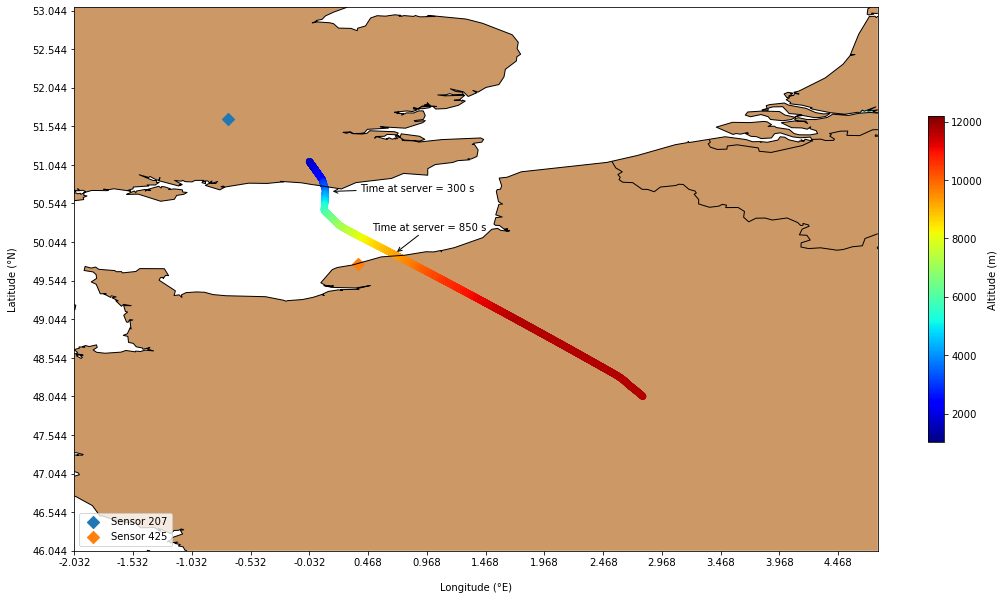

In [35]:
lat = air181_exp.loc[air181_exp.timeAtServer.between(0, 2000), 'latitude'].values
long = air181_exp.loc[air181_exp.timeAtServer.between(0, 2000), 'longitude'].values
geoAltitude = air181_exp.loc[air181_exp.timeAtServer.between(0, 2000), 'geoAltitude'].values

fig, ax = plt.subplots(figsize=(18,10))

# Define lower left, uperright lattitude and longitude respectively
ll_lat, up_lat, ll_long, up_long = min(lat)-2, max(lat)+2, min(long)-2, max(long)+2

# Create a Basemap instance
# In order to use the resolutions highere than 'l' (low) you have to download and
# install those files separately with: conda install -c conda-forge basemap-data-hires
m = Basemap(llcrnrlon=ll_long, llcrnrlat=ll_lat,
             urcrnrlon=up_long, urcrnrlat=up_lat,
             epsg=4326, resolution='i',
             fix_aspect=False, ax=ax) 


s1x, s1y = sensor_data.loc[sensor_numbers[0]-1, ['latitude', 'longitude']]
s2x, s2y = sensor_data.loc[sensor_numbers[1]-1, ['latitude', 'longitude']]
                           
ax.scatter(s1y, s1x, label='Sensor {}'.format(sensor_numbers[0]), marker='D', s=75)
ax.scatter(s2y, s2x, label='Sensor {}'.format(sensor_numbers[1]), marker='D', s=75)
ax.legend()

m.drawcoastlines() # use only if coastline will be visible on the map
m.drawcountries(color='k', linewidth=1)
m.fillcontinents(color='#cc9966',lake_color='#99ffff', zorder=0)

plot = ax.scatter(long, lat, c=geoAltitude,  cmap="jet", vmin=min(geoAltitude)-500, vmax=max(geoAltitude)+500)
fig.colorbar(plot, label='Altitude (m)', shrink=0.6)

ax.set_xlabel('Longitude (°E)', labelpad=15)
ax.set_ylabel('Latitude (°N)', labelpad=15)

meridians = np.arange(ll_long, up_long, 0.5)
parallels = np.arange(ll_lat, up_lat, 0.5)
ax.set_yticks(parallels)
ax.set_yticklabels(np.round(parallels, 3))
ax.set_xticks(meridians)
ax.set_xticklabels(np.round(meridians, 3))

x1, y1 = m(0.4, 50.7)
ax.annotate('Time at server = 300 s', xy=(0.15, 50.7), xycoords='data', xytext=(x1, y1), 
            textcoords='data', arrowprops={'arrowstyle': '->'})

x2, y2 = m(0.5, 50.2)
ax.annotate('Time at server = 850 s', xy=(0.7, 49.9), xycoords='data', xytext=(x2, y2),
            textcoords='data', arrowprops={'arrowstyle': '->'})

plt.show()

The signal strength plots in conjunction with the map show that at the time when the plane flies above the English Channel, the RSSI significantly decreases, this phenomena has been reported by sensor 207 at the time from 300 s to 850 s (time at server). The <i>attenuation</i> of the signal seems to be brought about by the fact that the plane was flying above the water surface at that time.

To evaluate the loss of the signal strength above the water surface, we will fit the regression model into the RSSI data, but only on the parts of the route where the plane flies above the land. This model will be used to predict the signal strength value for the corresponding distance from the sensor, assuming that the loss is constant irrespective of the surface above which the aircraft flies. Each deviation of the real RSSI from the predicted value indicates the additional influence of the water surface on the signal loss.

In [36]:
# Determine whether given coordinate point is in land
in_land = air181_exp.apply(lambda x: m.is_land(x.longitude, x.latitude), axis=1)
in_land = in_land.loc[s207_idx]
in_land = in_land.loc[in_land == True]

In [37]:
# Filter RSSI values
s207_rssi_land = []
s207_dist_land = []
s207_rssi_water = []
s207_dist_water = []

for rssi, dist, idx in list(zip(s207_rssi, s207_dist, s207_idx)):
    if idx in list(in_land.index):
        s207_rssi_land.append(rssi)
        s207_dist_land.append(dist)
    else:
        s207_rssi_water.append(rssi)
        s207_dist_water.append(dist)

Now we will fit the linear regression model into the data.

In [38]:
from sklearn.linear_model import LinearRegression

s207_dist_land = np.array(s207_dist_land).reshape(-1, 1)
reg = LinearRegression().fit(s207_dist_land, s207_rssi_land)

print('Coefficient of determination R^2: ', reg.score(s207_dist_land, s207_rssi_land))

Coefficient of determination R^2:  0.7063388307405261


In [39]:
coeff = reg.coef_
intercept = reg.intercept_

# Predict the RSSI for the distances that correspond to the flight above water
s207_dist_water = np.array(s207_dist_water).reshape(-1, 1)
pred_rssi_water = np.array(reg.predict(s207_dist_water)).reshape(-1, 1)

print('Coefficient of determination R^2 (water): ', reg.score(s207_dist_water, s207_rssi_water))
print('Mean square error: ', np.mean((pred_rssi_water - s207_rssi_water)**2))

Coefficient of determination R^2 (water):  -0.5702870519096526
Mean square error:  2873.961148967548


The negative value of the coefficient of determination implies that the regression model that was fitted into the 'land' RSSI data doesn't describe at all the relationship between distance and RSSI for the 'water' flight-route. This happened due to an order of magnitude greater loss of signal strength when transmitting over the water's surface. Thus it is necessary to distinguish between those two types of surfaces and model them separately.

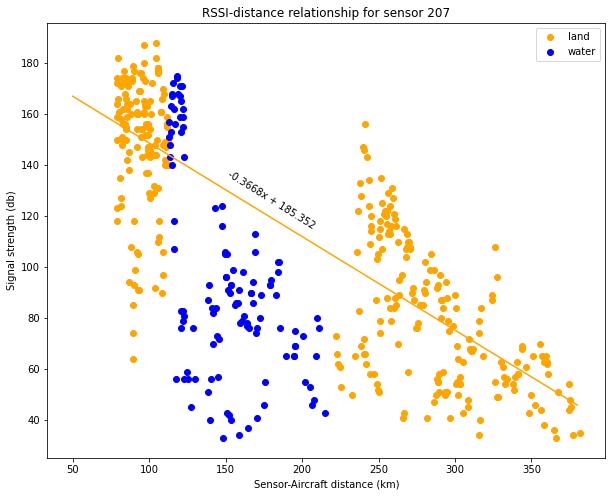

In [40]:
plt.figure(figsize=(10, 8))

plt.scatter(s207_dist_land, s207_rssi_land, label='land', color='orange')
plt.scatter(s207_dist_water, s207_rssi_water, label='water', color='b')
plt.xlabel('Sensor-Aircraft distance (km)')
plt.ylabel('Signal strength (db)')
plt.legend()
plt.title('RSSI-distance relationship for sensor 207')

x1, x2 = 50, 380
y1, y2 = x1 * coeff + intercept, x2 * coeff + intercept
 
plt.plot([x1, x2], [y1, y2], 'orange')
plt.text(150, 115, '-0.3668x + 185.352', rotation=-32)

plt.show()

### BaroAltitude and GeoAltitude

To fully establish the position of an aircraft, besides its geographical coordinates we have to know its altitude. The geometric height of the aircraft can be estimated based on the barometric altitude provided.

We will begin by examining how the distribution of geometric and barometric altitude differences looks like.

In [41]:
altitude_diff = flights.geoAltitude - flights.baroAltitude 

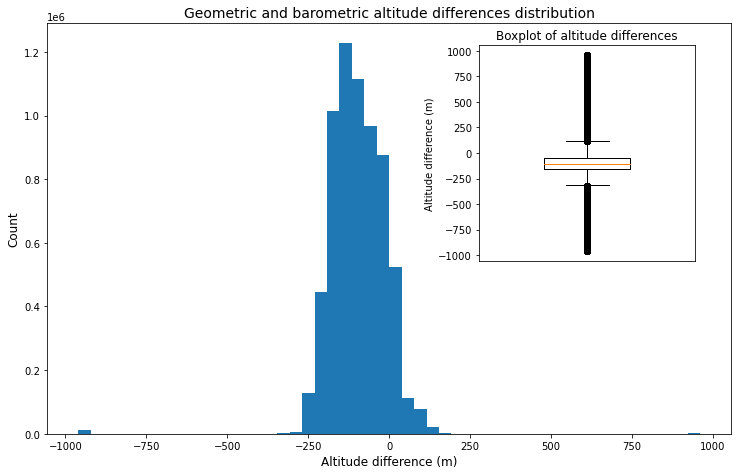

In [42]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_axes([0, 0, 0.95, 0.95]) # window coord: (left, bottom, width, height)(in %)
ax1.hist(altitude_diff, bins=50)
ax1.set_title('Geometric and barometric altitude differences distribution', size=14)
ax1.set_xlabel('Altitude difference (m)', size=12)
ax1.set_ylabel('Count', size=12)

ax2 = fig.add_axes([0.6, 0.4, 0.3, 0.5]) # window coord: (left, bottom, width, height)(in %)
ax2.boxplot(altitude_diff, widths=0.4)
ax2.set_title('Boxplot of altitude differences')
ax2.set_ylabel('Altitude difference (m)')
ax2.set_xticks([0])

plt.show()

The shape of the geometric and barometric altitude differences distribution resembles the Beta distribution. Most of the values lie within the range of -250 to 200 meters of altitude difference. There are some outliers, few altitude readings reported the difference as high as 1000 meters, which probably stems from the distorted measurements, either of the geometric or barometric altitude.

In the next table, we will present some basic statistics of the aforementioned distribution.

In [43]:
pd.DataFrame(altitude_diff.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round())

,0
count,6535444.0
mean,-99.0
std,85.0
min,-960.0
5%,-213.0
25%,-152.0
50%,-107.0
75%,-46.0
95%,23.0
max,960.0


Below we will check whether the altitude difference is dependent on the aircraft localization.

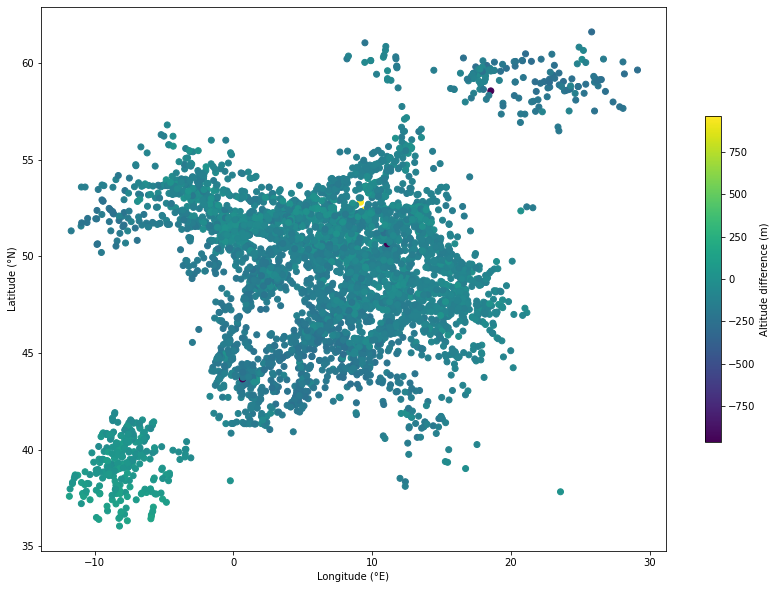

In [44]:
fig = plt.figure(figsize=(14,10))

# Select a random sample of indices
rand_idx = np.random.randint(min(flights.index), max(flights.index), size=5000)

plot = plt.scatter(flights.loc[rand_idx, 'longitude'], flights.loc[rand_idx, 'latitude'],
                   c=altitude_diff.loc[rand_idx])
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

fig.colorbar(plot, label='Altitude difference (m)', shrink=0.6)

plt.show()

It is time to calculate the mean altitude difference for each aircraft so that we will be able to identify the planes that most frequently report the inconsistent geometric and barometric altitudes.

In [34]:
altitude_diff = pd.concat([flights.aircraft, altitude_diff], axis=1)
altitude_diff.rename({0: 'altitude_diff'}, axis=1, inplace=True)

In [35]:
altitude_diff.head()

,aircraft,altitude_diff
0,109,0.00
1,840,-60.96
2,1819,-68.58
3,794,76.20
4,719,-152.40


In [36]:
maen_altitude_diff = altitude_diff.groupby('aircraft').altitude_diff.mean()

Now we will pick out aircrafts whose mean altitude difference falls below the 5th and goes beyond the 95th percentile.

In [37]:
maen_altitude_diff.loc[~maen_altitude_diff.between(-250, 50)]

aircraft
35       59.230307
37       92.785123
40      182.880000
73       53.269444
134      53.340000
           ...    
2833     55.880000
2850    135.401538
2853     70.281800
2881     61.936007
2887     77.154010
Name: altitude_diff, Length: 142, dtype: float64

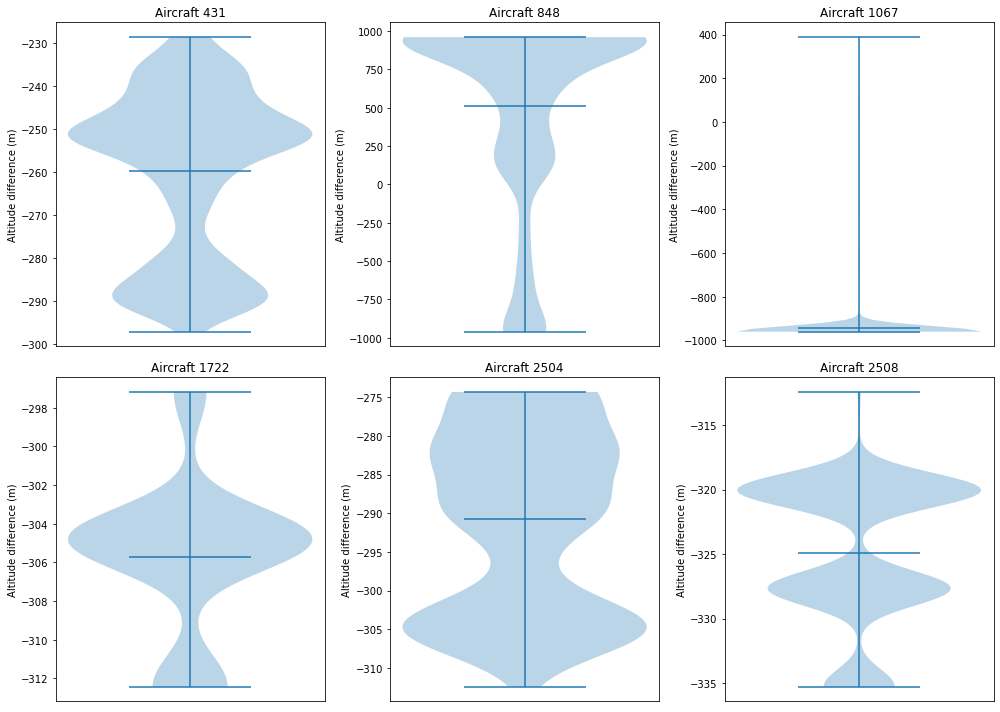

In [38]:
aircrafts = [431, 848, 1067, 1722, 2504, 2508]

fig, axes = plt.subplots(2, 3, figsize=(14,10), sharex=False)
count = 0

# Iterate through rows and columns
for row in range(2):
    for col in range(3):
        axes[row, col].violinplot(altitude_diff.loc[altitude_diff.aircraft == aircrafts[count], 'altitude_diff'],
                                  widths=0.7, showmeans=True)

        axes[row, col].set_title('Aircraft {}'.format(aircrafts[count]))
        axes[row, col].set_ylabel('Altitude difference (m)')

        axes[row, col].set_xticks([0])

        count += 1
        
plt.tight_layout()

From the above plot, we can draw the following conclusions:
- the distributions of altitude differences differ in terms of their shapes
- for the Aircraft 432 the baroAltitude is on average 260 meters greater than the geoAltitude
- distribution of altitude differences for Aircraft 848 contains an immense amount of outliers, most with the value of 1000 meters, while the mean altitude difference equals 500 meters
- distribution for Aircraft 1067 consist mainly of the outliers with the -900 meters altitude difference
- for the Aircraft 1722 and 2504 the range of values is much smaller (up to 35 meters). For both distributions, the baroAltitude is on average around 300 meters greater than the geoAltitude
- the range of values for the last distribution is also very small (up to 20 meters), we can distinguish here 3 sets of altitude difference where most of the values belong to.